# Code to compute the temperature profile evolution in two Arctic sites.

F. Domine, K. Fourteau, G. Picard, G. Lackner, D. Sarrazin, M. Poirier, Shrubs covered by snow in the high Arctic cool down permafrost in winter by thermal bridging through frozen branches, Nature Geoscience, 2022

In [2]:
# install mfm if needed
# !pip install git+https://github.com/ghislainp/mfm --log tmp.log

# the other option is to point to mfm:
import sys
sys.path.append("../..")

In [3]:
import os
from glob import glob

import numpy as np
import pandas as pd

from mfm import MeteoData, Parameters, model_dirichlet, depth
from mfm.cranknicolson import cranknicolson_dirichlet

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# set this parameter to choose the site

location = "salix"

#location = "tundra"

In [5]:


if location == "tundra":
    # configuration for the tundra site
    met = pd.read_csv("data/Ttundra.csv", parse_dates=True, index_col=0)
    met += 273.15
    
    met = met.loc['2018-09-15':]  # start the simulation 15 Sep 2018
    
    nlyr_snow = 38  # 38 cm

    height_timeseries = [
        ('2018-09-01', 0),
        ('2018-10-11', 3),
        ('2018-10-18', 7),
        ('2018-11-12', 13),
        ('2018-11-30', 37),
        ('2018-12-05', 28),
        ('2018-12-11', 38),
    ]

    rho_snow = np.zeros(nlyr_snow)
    ks_snow_winter = np.zeros(nlyr_snow)
    ks_snow_spring = np.zeros(nlyr_snow)
    ks_snow_melt = np.zeros(nlyr_snow)
    
    # density. Each layer is 1 cm thick. 0 is the ground, 38 is the top
    rho_snow[0:10] = 220
    rho_snow[10:20] = 325
    rho_snow[20:38] = 350
    
    # conductivity of the snow layers
    ks_snow_winter[0:10] = 0.084
    ks_snow_winter[10:20] = 0.084
    ks_snow_winter[20:38] = 0.276
    
    ks_snow_spring[0:10] = 0.084
    ks_snow_spring[10:20] = 0.132
    ks_snow_spring[20:38] = 0.288

    ks_snow_melt[0:10] = 0.216
    ks_snow_melt[10:20] = 0.168
    ks_snow_melt[20:38] = 0.36
  
    spring_date = '2019-02-01'
    melt_date = '2019-05-01'

elif location == "salix":
  # configuration for the Salix site
    met = pd.read_csv("data/Tsalix.csv", parse_dates=True, index_col=0)
    met += 273.15

    met = met.loc['2018-09-15':]  # start the simulation 15 Sep 2018
    
    nlyr_snow = 40  # 40 cm

    height_timeseries = [
        ('2018-09-01', 0),
        ('2018-09-17', 3),
        ('2018-10-11', 10),
        ('2018-11-12', 14),
        ('2018-11-30', 40),
        ('2018-12-05', 35),
        ('2018-12-11', 40),
        ('2019-02-08', 38),
    ]

    rho_snow = np.zeros(nlyr_snow)
    ks_snow_winter = np.zeros(nlyr_snow)
    ks_snow_spring = np.zeros(nlyr_snow)
    ks_snow_melt = np.zeros(nlyr_snow)
    
    # density. Each layer is 1cm thick. 0 is the ground, 38 is the top
    rho_snow[0:10] = 210
    rho_snow[10:20] = 240
    rho_snow[20:40] = 330
      
    # conductivity of the snow layers
    ks_snow_winter[0:10] = 0.098
    ks_snow_winter[10:20] = 0.056
    ks_snow_winter[20:40] = 0.126
   
    ks_snow_spring[0:10] = 0.085
    ks_snow_spring[10:20] = 0.102
    ks_snow_spring[20:40] = 0.153

    ks_snow_melt[0:10] = 0.102
    ks_snow_melt[10:20] = 0.119
    ks_snow_melt[20:40] = 0.238

    spring_date = '2019-01-01'
    melt_date = '2019-05-01'

else:
    raise Exception("Unknown location")


In [7]:
# soil characteristics.

nlyr_soil = 500  # 5 m
ks_soil_frozen = np.zeros(nlyr_soil)
rho_soil_frozen = np.zeros(nlyr_soil)
cp_soil_frozen = np.zeros(nlyr_soil)

ks_soil_summer = np.zeros(nlyr_soil)
rho_soil_summer = np.zeros(nlyr_soil)
cp_soil_summer = np.zeros(nlyr_soil)

freezing_date = '2018-10-24'

soil_layers = 2

# 2 LAYER SOIL
if soil_layers == 2:
  # summer (unfrozen) soil

  rho_soil_summer[0:10] = 1320.
  rho_soil_summer[10:500] = 1800.

  cp_soil_summer[0:10] = 600000.
  cp_soil_summer[10:500] = 1667.

  # conductivity of the soil layers
  ks_soil_summer[0:10] = 0.5    # soil ks 0-10cm
  ks_soil_summer[10:500] = 1.2  # soil ks 10cm -> 500cm

  # frozen soil

  rho_soil_frozen[0:10] = 1320.
  rho_soil_frozen[10:500] = 1800.

  cp_soil_frozen[0:10] = 1000.
  cp_soil_frozen[10:500] = 1000.

  # conductivity of the soil layers
  ks_soil_frozen[0:10] = 0.8    # soil ks 0-10cm
  ks_soil_frozen[10:500] = 2  # soil ks 10cm -> 500cm

else:
  raise Exception("Invalid soil_layers")

Text(0.5, 0, 'Conductivité')

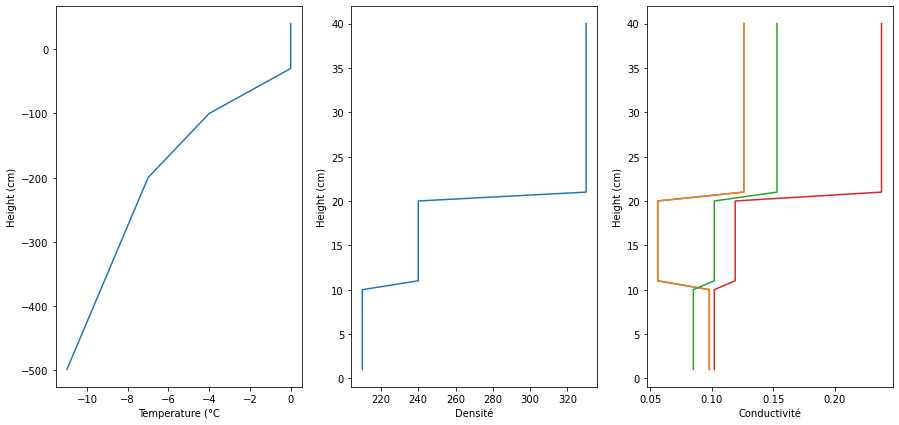

In [8]:

mean_tair = np.mean(met['Tair'])

nlyr = nlyr_snow + nlyr_soil

cp_snow = [152.75 + 7.1 * mean_tair] * nlyr_snow

periods = pd.to_datetime([freezing_date, spring_date, melt_date])
params_list = [None] * (len(periods) + 1)

params_list[0] = Parameters(dt=100,  # timestep 100 s
                    dx=1e-2 * np.ones(nlyr),  # layers are 1cm
                    cp=np.array(cp_snow + list(cp_soil_summer)),  # for the ice and soil
                    ks=np.array(list(reversed(ks_snow_winter)) + list(ks_soil_summer)),
                    rho=np.array(list(reversed(rho_snow)) + list(rho_soil_summer)))

params_list[1] = Parameters(dt=params_list[0].dt,
                    dx=params_list[0].dx,
                    cp=np.array(cp_snow + list(cp_soil_frozen)),  # for the ice and soil
                    ks=np.array(list(reversed(ks_snow_winter)) + list(ks_soil_frozen)),
                    rho=np.array(list(reversed(rho_snow)) + list(rho_soil_frozen)))

params_list[2] = Parameters(dt=params_list[0].dt,
                    dx=params_list[0].dx,
                    cp=np.array(cp_snow + list(cp_soil_frozen)),  # for the ice and soil
                    ks=np.array(list(reversed(ks_snow_spring)) + list(ks_soil_frozen)),
                    rho=np.array(list(reversed(rho_snow)) + list(rho_soil_frozen)))

params_list[3] = Parameters(dt=params_list[0].dt,
                    dx=params_list[0].dx,
                    cp=np.array(cp_snow + list(cp_soil_frozen)),  # for the ice and soil
                    ks=np.array(list(reversed(ks_snow_melt)) + list(ks_soil_frozen)),
                    rho=np.array(list(reversed(rho_snow)) + list(rho_soil_frozen)))

z = depth(params_list[0]) + nlyr_snow * 1e-2

# initial temperature profile
#
# Here, ajust the z0 and temp0 parameters to prescribe a realistic initial profile of temperature
#
z0    = [30, 5, 0, -5, -10, -30, -100, -200, -500]   # depths in centimeter  (positive = snow, negative = soil, 0 = interface soil/snow)
temp0 = [0, 0, 0, 0, 0, 0, -4, -7,-11] # temperature at each depth


#-
o = np.argsort(z0)
temp = np.interp(z * 100, np.array(z0)[o], np.array(temp0)[o] + 273.15)
for i in range(len(params_list)):
  params_list[i].tbase = temp[-1]

f, axs = plt.subplots(1, 3, figsize=(15, 7))
axs[0].plot(temp - 273.15, z * 100)
axs[0].set_ylabel("Height (cm)")
axs[0].set_xlabel("Temperature (°C")

axs[1].plot(params_list[i].rho[0:nlyr_snow], z[0:nlyr_snow] * 100)
axs[1].set_ylabel("Height (cm)")
axs[1].set_xlabel("Densité")

for i in range(4):
  axs[2].plot(params_list[i].ks[0:nlyr_snow], z[0:nlyr_snow] * 100)
axs[2].set_ylabel("Height (cm)")
axs[2].set_xlabel("Conductivité")


In [9]:


def get_meteo(met):
    for dt, m in met.groupby('time_stamp'):
        #yield dt, float(m['Tair'])
        yield dt, float(m['Tsurf'])

height_timeseries_copy = height_timeseries.copy()

iperiod = 0
params = params_list[iperiod]

temp_arr = []
i = 0
itop = 0
o_time = []
for spin in [0]:
    for dt, ts in get_meteo(met):  # hourly loop
        if iperiod < len(periods) and dt > periods[iperiod]:
            iperiod += 1
            params = params_list[iperiod]

        if height_timeseries_copy and (dt >= pd.to_datetime(height_timeseries_copy[0][0])):
           if itop > 0:
             temp[0:itop] = temp[itop]  # copy the surface temperature up
           itop = nlyr_snow - int(np.round(height_timeseries_copy.pop(0)[1]))
           if itop < 0:
             print("Error: the height in 'height_date' is too large compared to 'nlyr_snow'")

        for j in range(0, 3600, params.dt):  # sub-hourly loop
            otemp = np.full_like(temp, np.nan)
            otemp[itop:] = cranknicolson_dirichlet(temp[itop:], ts, params.dt, params.dx[itop:], params.ks[itop:],
                               params.rho[itop:], cpice=params.cp[itop:], tbase=params.tbase) # run the model for 1 timestep
            temp = otemp
            if spin == 0 and (j % 3600) == 0:  # output temperature every hour
                o_time.append(dt + np.timedelta64(j, 's'))
                temp_arr.append(temp)
      
    i += 1
    
temp_arr = np.array(temp_arr)
o_time = pd.DatetimeIndex(o_time)
temp_snow = temp_arr[:, nlyr_snow-1::-1]
temp_soil = temp_arr[:, nlyr_snow:]        

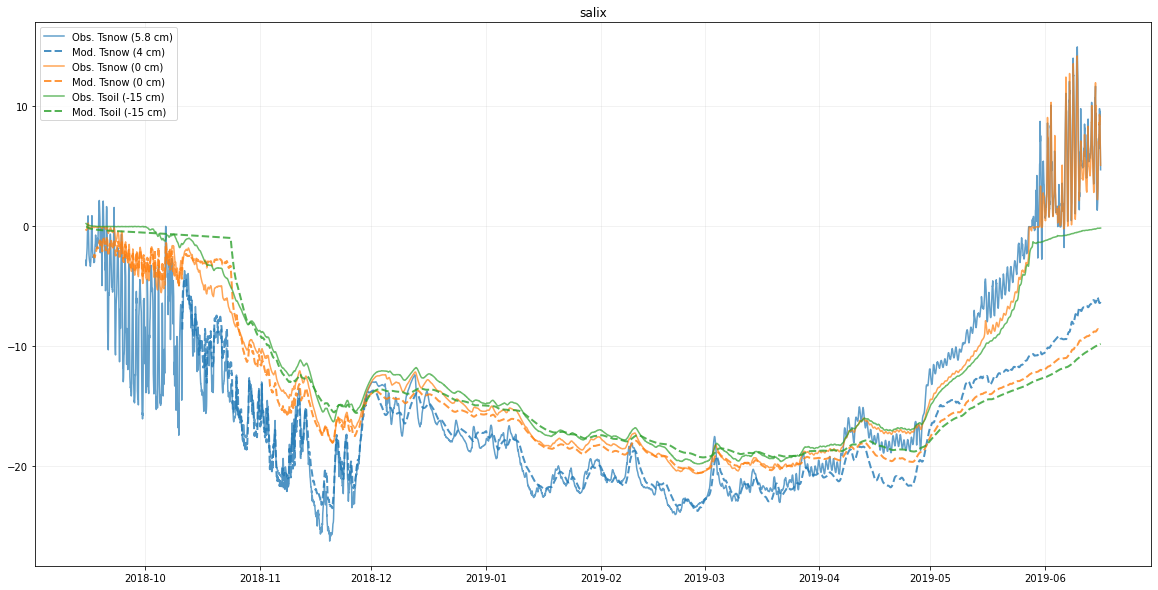

In [12]:
#plot

def plot():

  plt.figure(figsize=(20, 10))
  #plt.plot(met.index, met['Tair'] - 273.15, 'k', alpha=0.1, label='Tair')
  #plt.plot(met.index, met['Tsurf'] - 273.15, 'r', alpha=0.2, label='Tsurf')

  if location == "tundra":
      obsdepths = [5, 0, -15]
      moddepths = [3.5, 0, -15]
  elif location == "salix":
      obsdepths = [5.8, 0, -15]
      moddepths = [4, 0, -15]

  out = []
  for md, od in zip(moddepths, obsdepths):
      if md < 0:
        temp = temp_soil
        title = "Tsoil"
      else:
        temp = temp_snow
        title = "Tsnow"
      idepth = int(np.abs(np.round(md)))

      l, = plt.plot(met.index, met[f'{od} cm'] - 273.15, alpha=0.7, label=f'Obs. {title} ({od} cm)')
      plt.plot(o_time, temp[:, idepth] - 273.15, '--', lw=2, alpha=0.8, label=f'Mod. {title} ({md} cm)', color=l.get_color())
      out.append(temp[:, idepth] - 273.15)

  plt.title(location)
  plt.legend()
  plt.grid(alpha=0.2)

  df = pd.DataFrame(np.transpose(out), columns=moddepths, index=o_time)

  #df.to_excel(f'results-{location}.xls')  # save as an excel file
  df.to_csv(f'results-{location}.csv')     # save as a csv file

plot()

(-20.0, -10.0)

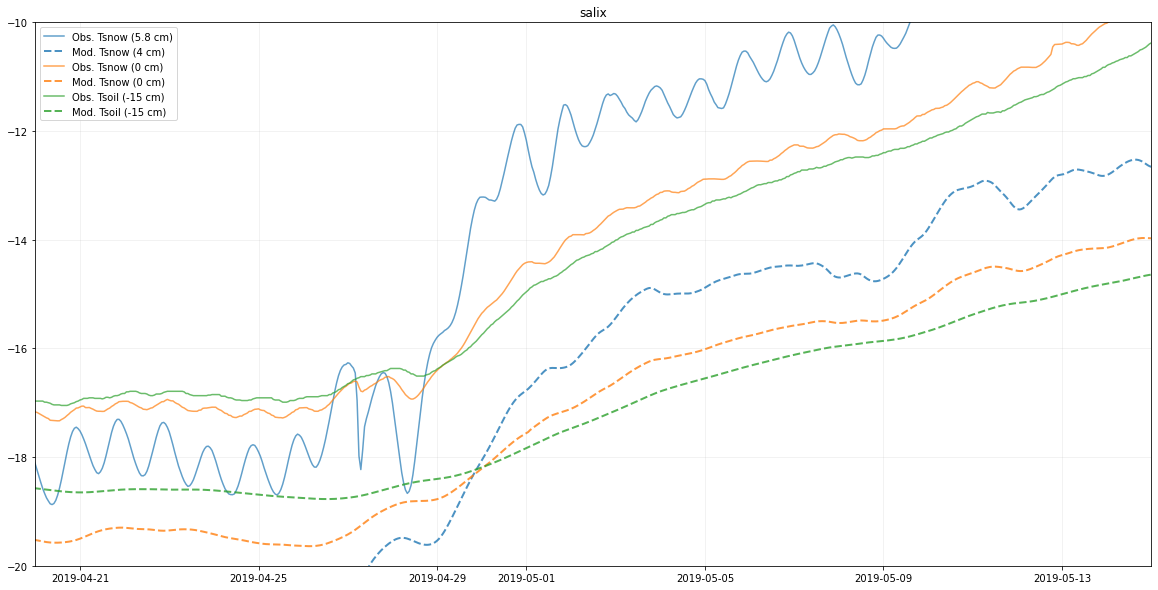

In [13]:
plot()
plt.xlim(pd.date_range('2019-04-20', '2019-05-15')[[0, -1]])
plt.ylim((-20, -10))